In [5]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_validate
from sklearn.preprocessing import StandardScaler
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import homework_utils


ModuleNotFoundError: No module named 'tf'

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.gpu_device_name())
#tf.keras.mixed_precision.set_global_policy('mixed_float16')

Num GPUs Available:  1
/device:GPU:0


In [4]:
# Load data into pandas DataFrame
df = pd.read_parquet('dataset/unscaled_train_data.parquet')

# Define the feature and target columns
feature_cols = df.columns[:-1]
target_col = df.columns[-1]
O = len(df[target_col].unique())
I = len(feature_cols)

# Define a function to create the Keras model
def create_model(hidden_size:int,lr:float=None,m:float=None):
    model = Sequential()
    model.add(Dense(hidden_size, input_dim=len(feature_cols), activation='sigmoid'))
    model.add(Dense(O, activation='softmax'))
    if lr and m:
        optimizer = SGD(learning_rate=lr,momentum=m)
    else:
        optimizer = Adam(learning_rate=0.01)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_crossentropy','mean_squared_error','accuracy'])
    return model

# Create a 5-fold cross-validation object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Encode data
x = df[feature_cols]
y = to_categorical(df[target_col])

In [1]:
from importlib import reload

import numpy as np
reload(homework_utils)
scores = []
hidden_layer_matrice = [
    {"hidden_size":I,}, 
    {"hidden_size":int((2*I+O)/2),}, 
    {"hidden_size":I+O,}, 
]

reload(homework_utils)
import logging
logging.getLogger().setLevel(logging.INFO)

hiddensize_test_resuts = homework_utils.wrap_test_case(hidden_layer_matrice,create_model,df[feature_cols].values,df[target_col].values)

NameError: name 'homework_utils' is not defined

In [12]:
for result in hiddensize_test_resuts:
    print(result.testcase)
    homework_utils.print_scores(homework_utils.score_from_histories(result.histories))
    print("="*30)

{'hidden_size': 15}
Validation Cross Entropy: 0.0715 (+/- 0.0024)
Validation MSE: 0.0064 (+/- 0.0002)
Validation Accuracy: 0.9798 (+/- 0.0006)
{'hidden_size': 17}
Validation Cross Entropy: 0.0639 (+/- 0.0018)
Validation MSE: 0.0059 (+/- 0.0003)
Validation Accuracy: 0.9811 (+/- 0.0013)
{'hidden_size': 20}
Validation Cross Entropy: 0.0530 (+/- 0.0022)
Validation MSE: 0.0048 (+/- 0.0001)
Validation Accuracy: 0.9848 (+/- 0.0006)


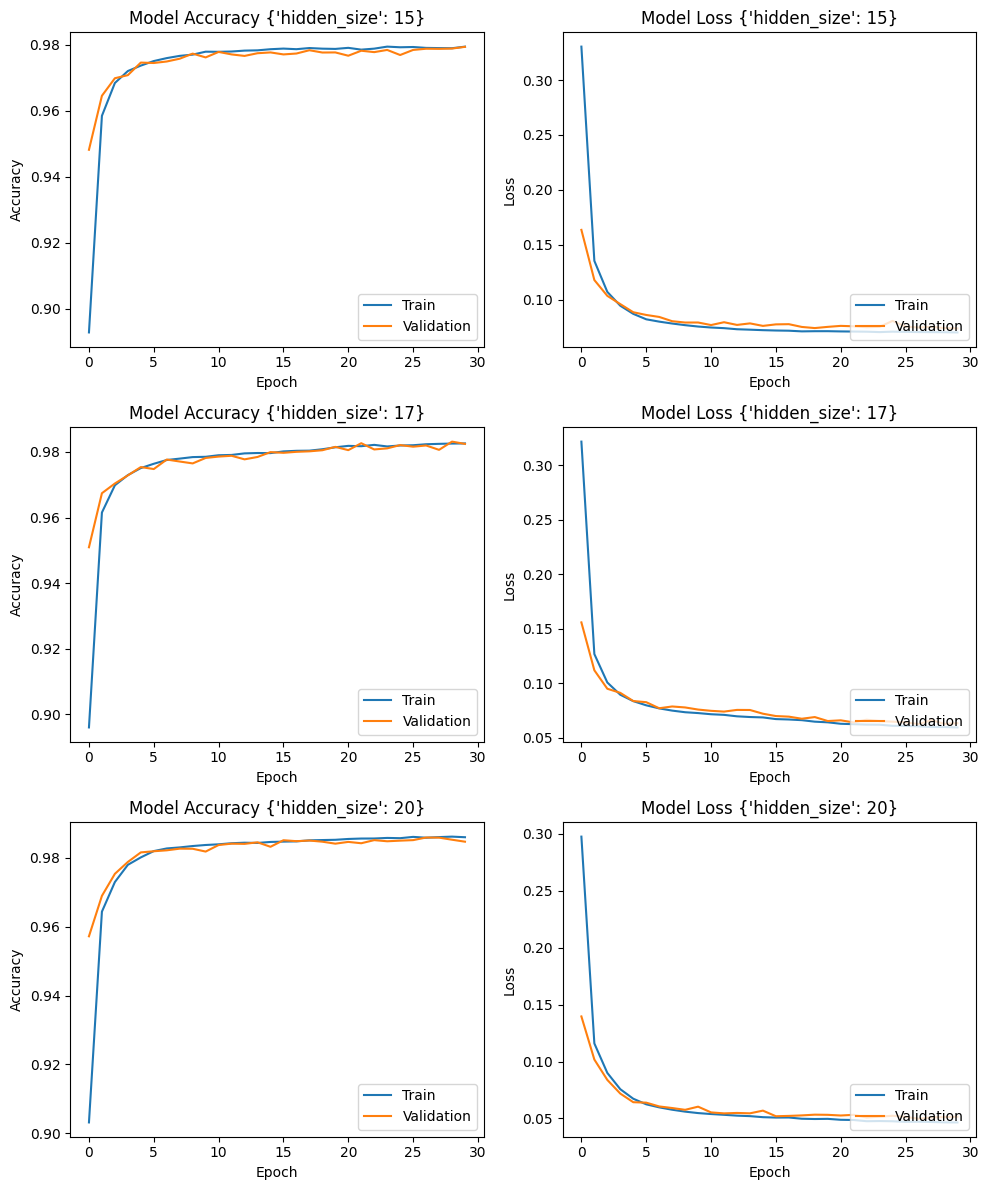

In [16]:
reload(homework_utils)

# set up the figure
homework_utils.figure_from_histories([I.histories[0] for I in hiddensize_test_resuts],[I.testcase for I in hiddensize_test_resuts])

In [ ]:
lr_m_matrice=[
    {'lr':0.001,'m':0.2},
    {'lr':0.001,'m':0.6},
    {'lr':0.05,'m':0.6},
    {'lr':0.1,'m':0.6},
]
from importlib import reload

import numpy as np

reload(homework_utils)
import logging
logging.getLogger().setLevel(logging.INFO)

lr_m_test_results = homework_utils.wrap_test_case(lr_m_matrice,create_model,df[feature_cols].values,df[target_col].values)

In [ ]:
for result in lr_m_test_results:
    print(result.testcase)
    homework_utils.print_scores(homework_utils.score_from_histories(result.histories))
    print("="*30)

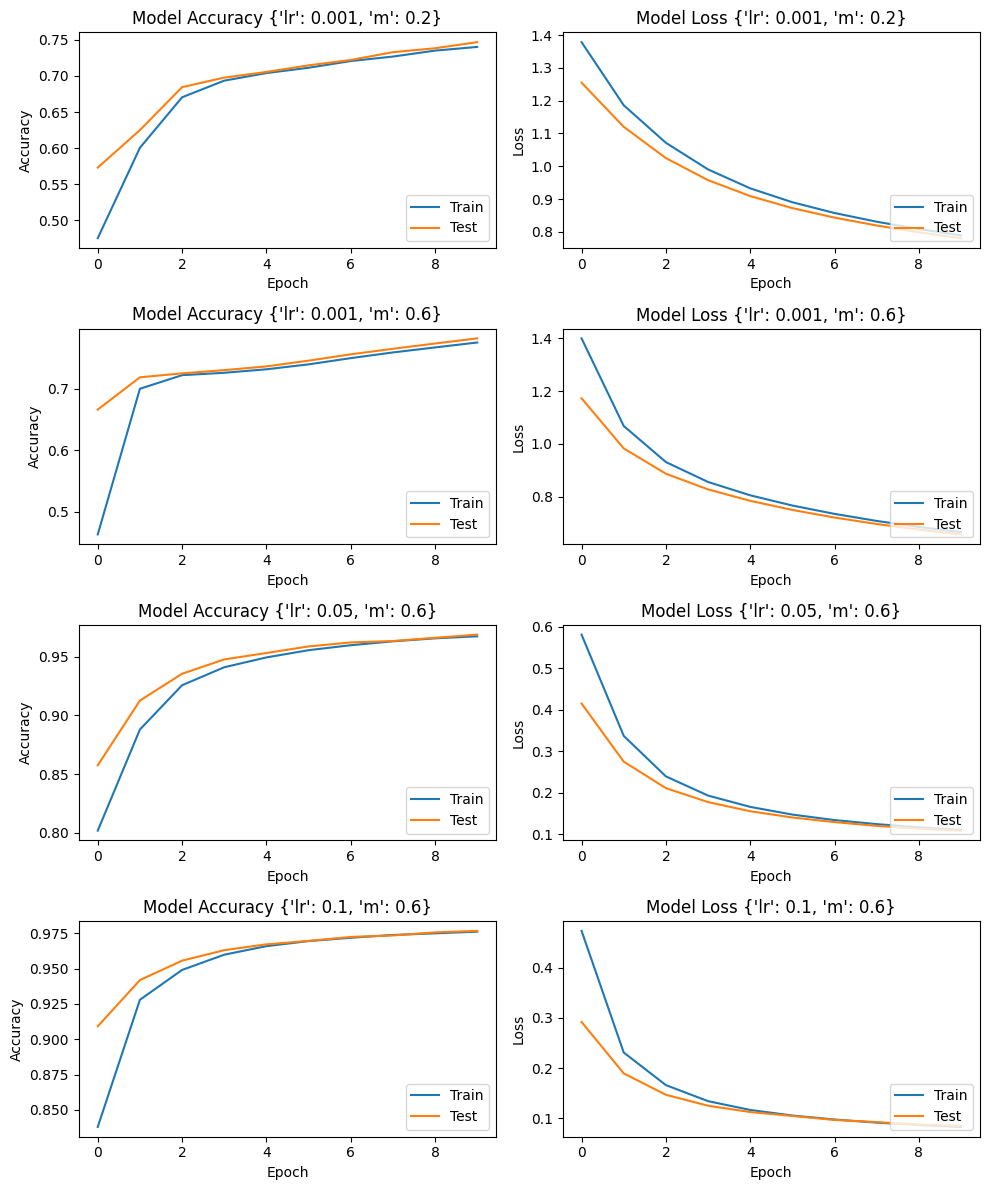

In [72]:
# set up the figure
figure_from_histories([I.histories[0] for I in lr_m_test_results],[I.testcase for I in lr_m_test_results])


In [ ]:
from keras import regularizers
def create_normalised_model(coef):
    model = Sequential()
    model.add(Dense(I+O, input_dim=len(feature_cols), activation='sigmoid',bias_regularizer=regularizers.L2(coef)))
    model.add(Dense(O, activation='softmax'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_crossentropy','mean_squared_error','accuracy'])
    return model

In [ ]:
test_matrice_reg=[
    {'coef':0.1},
    {'coef':0.5},
    {'coef':0.9},
]

histories = []
for cond in test_matrice_reg:
    for fold_idx, (train_indices, val_indices) in enumerate(kf.split(df[feature_cols])):
        X = df[feature_cols].values[train_indices]
        Y = to_categorical(df[target_col].values[train_indices])
        Xv = df[feature_cols].values[val_indices]
        Yv = to_categorical(df[target_col].values[val_indices])

        model = create_normalised_model(cond['coef'])
        X = StandardScaler().fit_transform(X)
        Xv = StandardScaler().fit_transform(Xv)
        history = model.fit(X,Y,epochs=10,batch_size=64,validation_data=(Xv,Yv),verbose=0)
        histories.append(history)


#TODO create score from histories
